## Self supervised large scale generalisation - Random 

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [2]:
s3_prefixes = []
for (t,p, m) in [(2000, 500, 0), (4000,1000,0), (6000,1500, 0), (8000,2000,0), (10000,2500,0)]:
    for i in ["00", "01", "02", "03", "04"]:
        s3_prefixes.append(f"s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-random-{t}-{p}-{m}-bert-f1-{i}-202212261346/202212281205/")

In [3]:
label_order = ["False", "True"]
pos_labels = list( filter(lambda x: x , label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {}

In [4]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [5]:
import shutil
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)

    


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        

In [6]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        list_df.append(df)
    return pd.concat(list_df)


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



keywords1 = ["activation", "trigger", "interact", "inhibit", "regulat", "supress"]

keywords2 = ["gene", "protein", "chemical"]

def self_label(df):
   

    df["self_label"] = df["abstract"].apply(lambda x: any([ k.lower() in x.lower() for k in keywords1]) 
                                        and sum([  k.lower() in x.lower() for k in keywords2])>=2
                                     
                                       ).astype(str)
    
    
    return df

def plot_confusionmatrix(y_true,y_pred, normalize=None):
    cm = confusion_matrix(y_true,y_pred,labels=["False", "True"], normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =  ["False", "True"])
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [8]:


def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in sorted(os.listdir(local_temp_pred_dir)):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        df=df.pipe(self_label)
        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id", "self_label"]])

 
    return  pd.concat(list_df_summary)




In [9]:
%%time 

from sklearn.metrics import precision_recall_fscore_support
import regex as re
import io, sagemaker

def create_stats_df(s3_prefix, confidence=0.0):
    print(f"Running {s3_prefix}, confidence {confidence}")

    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)
    df = get_summary_df (local_temp_pred_dir)


    total_predictions= len(df)
    df = df.query(f"confidence > {confidence} ")

    name = s3_prefix
    r = re.search(  "predictions_selfsup-random-(\d+)-(\d+)-(\d+)", s3_prefix)
    name= s3_prefix
    train_size= int(r.group(1))
    train_pos_size= int(r.group(2))
    train_affable=  int(r.group(3))
    prediction_above_threshold = len(df)

    p,r,f,s = precision_recall_fscore_support(df["self_label"], 
                         df["prediction"], pos_label = "True", average="binary", zero_division=0)
        
    return { "Name": name, 
                    "Precision":p*100,
                    "Recall":r*100,
                    "F1":f*100,  
                  #  "Threshold": "HighConfidence", 
                    "Support": s, 
                        "TrainSize":train_size, "TrainSizePositive": train_pos_size,
                        "TrainAffable" : train_affable,
                        "TrainAffableRate" : train_affable/train_size,
                        "PredictionsSize": total_predictions, 
                   "PredictionsAboveThresholdSize": prediction_above_threshold,
                    "PredictionsAboveThresholdRatio" :prediction_above_threshold/total_predictions
           
           }
    
    

def create_stats_dfs_from_prefixes(s3_prefixes):
    result = [ create_stats_df(s, confidence=0.0) for s in s3_prefixes]
    df =  pd.DataFrame(result)
    return df

df_stats = create_stats_dfs_from_prefixes(s3_prefixes)

Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-random-2000-500-0-bert-f1-00-202212261346/202212281205/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-random-2000-500-0-bert-f1-01-202212261346/202212281205/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-random-2000-500-0-bert-f1-02-202212261346/202212281205/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-random-2000-500-0-bert-f1-03-202212261346/202212281205/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-random-2000-500-0-bert-f1-04-202212261346/202212281205/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-random-4000-1000-0-bert-f1-00-202212261346/202212281205/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-random-4000-1000-0-bert-f1-01-202212261346/202212281205/, confidence 0.0
Runn

No handles with labels found to put in legend.


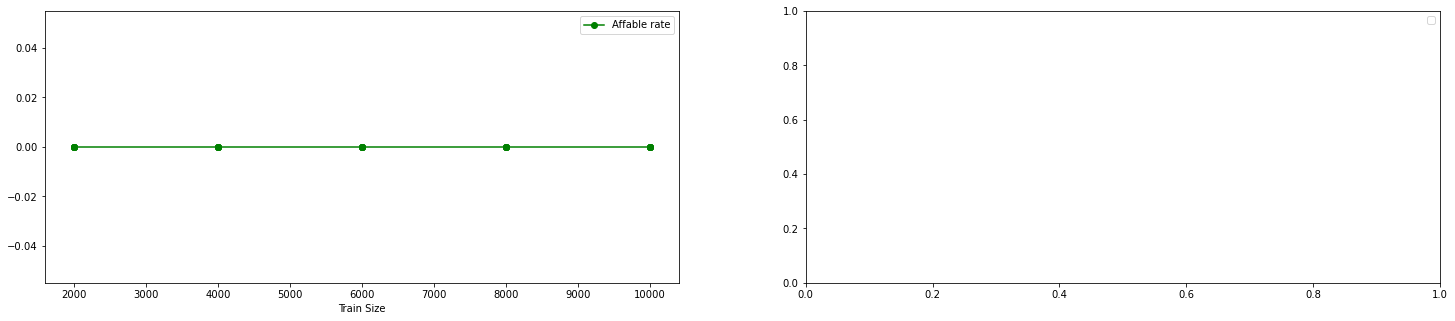

In [10]:
import warnings, matplotlib.pyplot as plt

def plot_comparison(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,2, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainAffableRate" : "Affable rate" ,
                        "TrainSize": "Train Size",
                        "Recall" : "Recall" , 
                        "F1": "F1" , 
                       }

        df[["TrainSize", "TrainAffableRate"]]\
            .rename(columns=column_renames)\
            .plot(x="Train Size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))

       
        plt.legend()

plot_comparison(df_stats)   

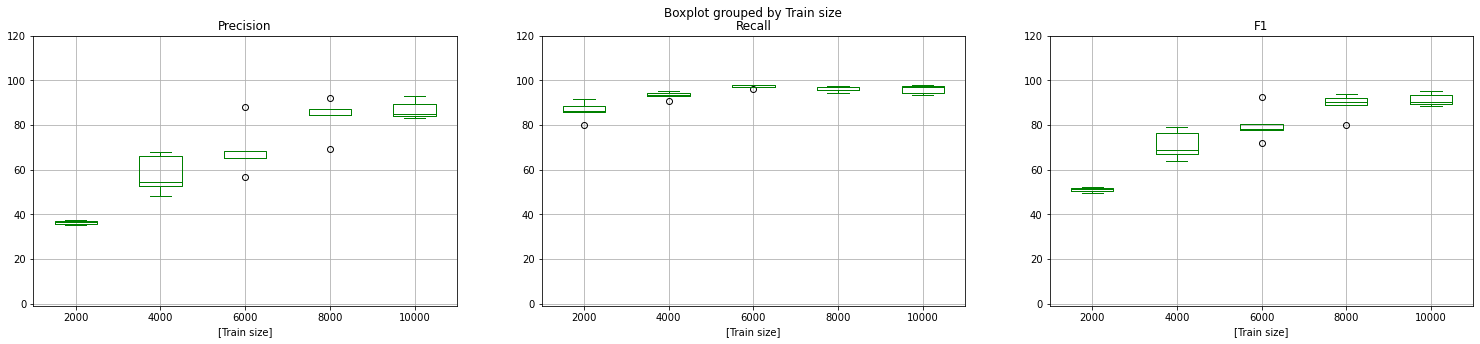

In [11]:
def plot_comparison_box(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,3, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainSize" : "Train size" ,
                        "Recall" : "Recall" , 
                        "TrainAffableRate" : "Affable rate" ,
                        "F1": "F1" , 
                       }
        ax[0].set_ylim(-1,120)
        df[["Precision", "TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[0], color="green")

        ax[1].set_ylim(-1,120)
        df[["Recall","TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[1], color="green")

        ax[2].set_ylim(-1,120)
        df[["F1","TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[2], color="green")


#         df[["TrainSize", "TrainAffableRate"]]\
#             .rename(columns=column_renames)\
#             .plot(x="Train size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))


    
        #plt.legend()

plot_comparison_box(df_stats)

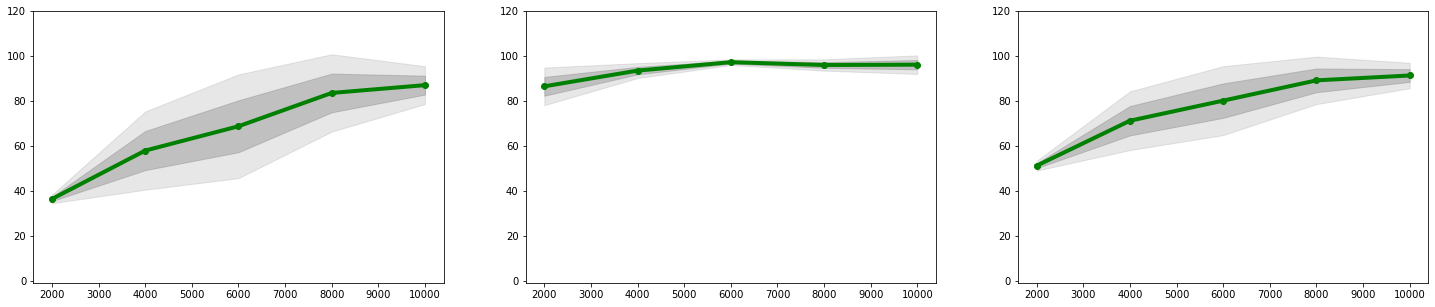

In [12]:
def plot_stdline(x, y_mean, y_std, ax, label):
    ax.plot(x, y_mean, color='green', label=label, linewidth = 4.0, marker='o')
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color='#888888', alpha=0.4)
    ax.fill_between(x, y_mean - 2*y_std, y_mean + 2*y_std, color='#888888', alpha=0.2)



def plot_comparison_linestd(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,3, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainSize" : "Train size" ,
                        "Recall" : "Recall" , 
                        "TrainAffableRate" : "Affable rate" ,
                        "F1": "F1" , 
                       }
        ax[0].set_ylim(-1,120)
        ldf = df.groupby("TrainSize")["Precision"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[0],  label='Precision')
       

        ax[1].set_ylim(-1,120)
        ldf = df.groupby("TrainSize")["Recall"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[1],  label='Recall')


        ax[2].set_ylim(-1,120)
        ldf = df.groupby("TrainSize")["F1"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[2],  label='F1')

        



#         df[["TrainSize", "TrainAffableRate"]]\
#             .rename(columns=column_renames)\
#             .plot(x="Train size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))


    
        #plt.legend()

plot_comparison_linestd(df_stats)

In [13]:
df_stats.groupby("TrainSize")[["Precision", "Recall", "F1"]].describe()



Precision                                                         \
              count       mean        std        min        25%        50%   
TrainSize                                                                    
2000            5.0  36.329463   0.947374  35.002373  35.837391  36.539975   
4000            5.0  57.859989   8.707370  48.225602  52.484219  54.508690   
6000            5.0  68.687299  11.546507  56.862935  65.063036  65.417699   
8000            5.0  83.521322   8.611193  69.139830  84.487235  84.533600   
10000           5.0  86.999854   4.209927  83.384334  84.019011  84.876141   

                                Recall             ...                        \
                 75%        max  count       mean  ...        75%        max   
TrainSize                                          ...                         
2000       36.781243  37.486333    5.0  86.461322  ...  88.320172  91.474759   
4000       66.105263  67.976169    5.0  93.466738  ...  94.389548  95.290859   
6000       68.185883  87.906942    5.0  97.219994  ...  97.730186  97.796337   
8000       87.387955  92.057992    5.0  95.965601  ...  96.870220  97.544135   
10000      89.570133  93.149653    5.0  96.105346  ...  97.606152  98.015463   

             F1                                                        \
          count       mean       std        min        25%        50%   
TrainSize                                                               
2000        5.0  51.131575  1.086591  49.507710  50.631029  51.526448   
4000        5.0  71.152648  6.535422  63.836034  67.141452  68.901094   
6000        5.0  80.097529  7.673200  71.746662  77.635090  78.189985   
8000        5.0  89.120453  5.284671  80.213198  89.169809  90.255976   
10000       5.0  91.291907  2.831193  88.530683  89.296912  90.109848   

                                 
                 75%        max  
TrainSize                        
2000       51.693305  52.299382  
4000       76.536031  79.348631  
6000       80.327590  92.588316  
8000       92.187164  93.776119  
10000      93.415638  95.106452  

[5 rows x 24 columns]

In [14]:
df_stats

,Name,Precision,Recall,F1,Support,TrainSize,TrainSizePositive,TrainAffable,TrainAffableRate,PredictionsSize,PredictionsAboveThresholdSize,PredictionsAboveThresholdRatio
0,s3://aegovan-data/selfsupervised_chemprot/pred...,35.002373,91.474759,50.631029,None,2000,500,0,0.0,500819,500819,1.0
1,s3://aegovan-data/selfsupervised_chemprot/pred...,36.539975,88.320172,51.693305,None,2000,500,0,0.0,500819,500819,1.0
2,s3://aegovan-data/selfsupervised_chemprot/pred...,36.781243,86.004879,51.526448,None,2000,500,0,0.0,500819,500819,1.0
3,s3://aegovan-data/selfsupervised_chemprot/pred...,35.837391,80.038864,49.507710,None,2000,500,0,0.0,500819,500819,1.0
4,s3://aegovan-data/selfsupervised_chemprot/pred...,37.486333,86.467937,52.299382,None,2000,500,0,0.0,500819,500819,1.0
5,s3://aegovan-data/selfsupervised_chemprot/pred...,66.105263,90.875264,76.536031,None,4000,1000,0,0.0,500819,500819,1.0
6,s3://aegovan-data/selfsupervised_chemprot/pred...,48.225602,94.389548,63.836034,None,4000,1000,0,0.0,500819,500819,1.0
7,s3://aegovan-data/selfsupervised_chemprot/pred...,67.976169,95.290859,79.348631,None,4000,1000,0,0.0,500819,500819,1.0
8,s3://aegovan-data/selfsupervised_chemprot/pred...,54.508690,93.620540,68.901094,None,4000,1000,0,0.0,500819,500819,1.0
9,s3://aegovan-data/selfsupervised_chemprot/pred...,52.484219,93.157481,67.141452,None,4000,1000,0,0.0,500819,500819,1.0


In [15]:
df_stats.groupby("TrainSize").describe().T

TrainSize                                     2000           4000   \
Precision                      count       5.000000       5.000000   
                               mean       36.329463      57.859989   
                               std         0.947374       8.707370   
                               min        35.002373      48.225602   
                               25%        35.837391      52.484219   
                               50%        36.539975      54.508690   
                               75%        36.781243      66.105263   
                               max        37.486333      67.976169   
Recall                         count       5.000000       5.000000   
                               mean       86.461322      93.466738   
                               std         4.184681       1.659370   
                               min        80.038864      90.875264   
                               25%        86.004879      93.157481   
                               50%        86.467937      93.620540   
                               75%        88.320172      94.389548   
                               max        91.474759      95.290859   
F1                             count       5.000000       5.000000   
                               mean       51.131575      71.152648   
                               std         1.086591       6.535422   
                               min        49.507710      63.836034   
                               25%        50.631029      67.141452   
                               50%        51.526448      68.901094   
                               75%        51.693305      76.536031   
                               max        52.299382      79.348631   
TrainSizePositive              count       5.000000       5.000000   
                               mean      500.000000    1000.000000   
                               std         0.000000       0.000000   
                               min       500.000000    1000.000000   
                               25%       500.000000    1000.000000   
                               50%       500.000000    1000.000000   
                               75%       500.000000    1000.000000   
                               max       500.000000    1000.000000   
TrainAffable                   count       5.000000       5.000000   
                               mean        0.000000       0.000000   
                               std         0.000000       0.000000   
                               min         0.000000       0.000000   
                               25%         0.000000       0.000000   
                               50%         0.000000       0.000000   
                               75%         0.000000       0.000000   
                               max         0.000000       0.000000   
TrainAffableRate               count       5.000000       5.000000   
                               mean        0.000000       0.000000   
                               std         0.000000       0.000000   
                               min         0.000000       0.000000   
                               25%         0.000000       0.000000   
                               50%         0.000000       0.000000   
                               75%         0.000000       0.000000   
                               max         0.000000       0.000000   
PredictionsSize                count       5.000000       5.000000   
                               mean   500819.000000  500819.000000   
                               std         0.000000       0.000000   
                               min    500819.000000  500819.000000   
                               25%    500819.000000  500819.000000   
                               50%    500819.000000  500819.000000   
                               75%    500819.000000  500819.000000   
                               max    500819.000000  500819.000000   
Prediction

In [16]:
from scipy import stats


 
    
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Precision"], 
                df_stats.query("TrainSize == 8000")["Precision"])

Ttest_indResult(statistic=-12.18081275132426, pvalue=1.912786524136343e-06)

In [17]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Precision"], 
                df_stats.query("TrainSize == 8000")["Precision"])

Ttest_indResult(statistic=-12.18081275132426, pvalue=1.912786524136343e-06)

In [18]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Precision"], 
                df_stats.query("TrainSize == 10000")["Precision"])

Ttest_indResult(statistic=-26.256555293931207, pvalue=4.7563749282829745e-09)

In [19]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Recall"], 
                df_stats.query("TrainSize == 8000")["Recall"])

Ttest_indResult(statistic=-4.864145498560297, pvalue=0.0012492136308550905)

In [20]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["F1"], 
                df_stats.query("TrainSize == 10000")["F1"])

Ttest_indResult(statistic=-29.612490986282133, pvalue=1.8332367658675226e-09)